Copyright 2018 The Dopamine Authors.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Loading experiment statistics

This colab illustrates how you can load an experiment's statistics and plot it. We provide a sample statistics file for a
modified Rainbow agent trained on Dopamine. Note that the performance of this sample data is not reflective of the standard settings, it was compiled solely for illustrative purposes.

*  Example 1 shows how to use our colab utils to load the baselines and plot them against your experiment. 
*  Example 2 shows how to load the raw experiment statistics and plot using a different package.

To re-run this colab, run each cell in order.

In [ ]:
# @title Install necessary packages.
!pip install -U dopamine-rl

In [2]:
# @title Necessary imports and globals.

import numpy as np
import os
from dopamine.agents.dqn import dqn_agent
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags

BASE_PATH = '/tmp/colab_dope_run'  # @param
# GAMES = ['Asterix', 'Pong', 'SpaceInvaders']  # @param
GAMES = ['Cart']

/usr/local/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/usr/local/lib/python3.9/site-packages/gin/tf/__init__.py:48: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [ ]:
# @title Load the sample log files.

# For illustrative purposes, we are providing sample logs of the Rainbow agent
# trained without sticky actions.
!gsutil -q -m cp -R gs://download-dopamine-rl/colab/* /content/

## Example 1: Plot against Dopamine baselines

In [ ]:
# @title Load the baseline data

!gsutil -q -m cp -R gs://download-dopamine-rl/preprocessed-benchmarks/* /content/
experimental_data = colab_utils.load_baselines('/content')

In [ ]:
# @title Load the summarized sample data and add it to the global data frame.
import collections

# Now read the data for our samples in a summarized fashion. The files will be
# in the local directory /content/samples/rainbow/GAME_v4, so we make use of
# the parameter_set and job_descriptor parameters.
parameter_set = collections.OrderedDict([
    ('agent', ['rainbow']),
    ('game', GAMES)
])
sample_data = colab_utils.read_experiment(
    '/content/samples',
    parameter_set=parameter_set,
    job_descriptor='{}/{}_v4',
    summary_keys=['train_episode_returns'])
sample_data['agent'] = 'Sample Rainbow'
sample_data['run_number'] = 1
for game in GAMES:
  experimental_data[game] = experimental_data[game].merge(
      sample_data[sample_data.game == game], how='outer')

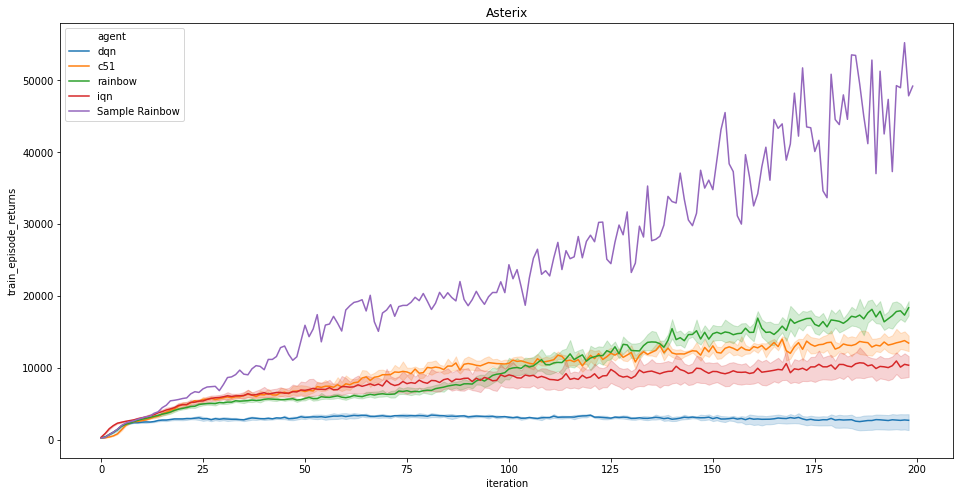

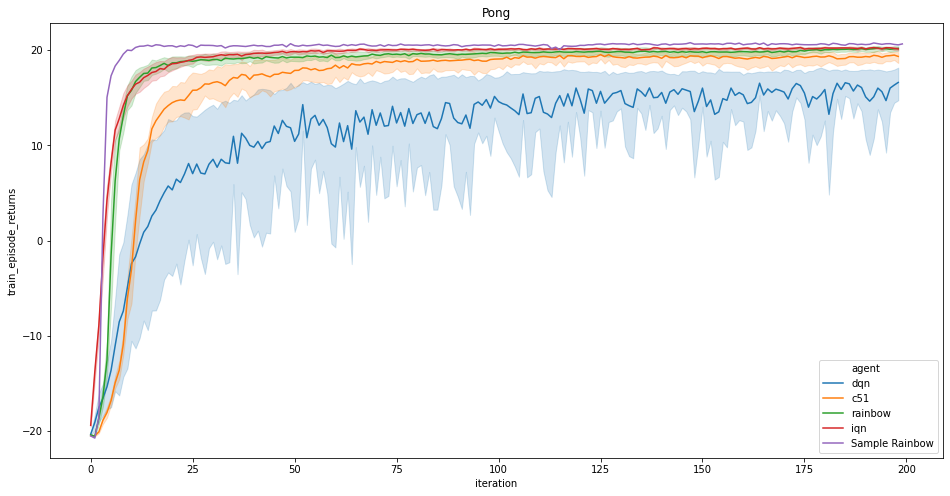

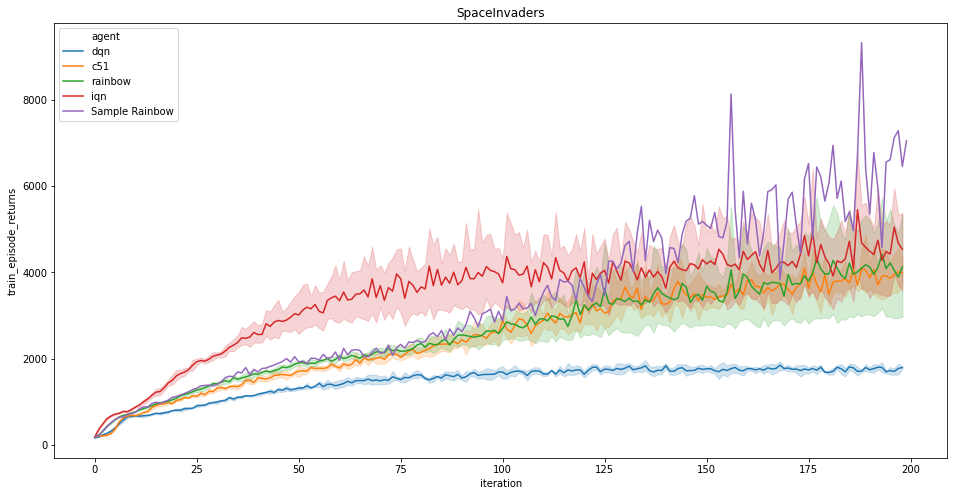

In [ ]:
# @title Plot the sample agent data against the baselines.

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

for game in GAMES:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(x='iteration', y='train_episode_returns', hue='agent',
               data=experimental_data[game], ax=ax)
  plt.title(game)
  plt.show()

## Example 2: Load the raw data for our sample experiments and plot using a different plotting package.

In [1]:

import matplotlib.pyplot as plt

for game in GAMES:
  # Use our provided colab utils to load this log file. The second returned 
  raw_data, _ = colab_utils.load_statistics(
      '/content/samples/rainbow/{}_v4/logs'.format(game), verbose=False)
  summarized_data = colab_utils.summarize_data(
      raw_data, ['train_episode_returns'])
  plt.plot(summarized_data['train_episode_returns'], label='episode returns')
  plt.plot()
  plt.title('Rainbow training - {}'.format(game))
  plt.xlabel('Iteration')
  plt.ylabel('Return')
  plt.legend()
  plt.show()

NameError: name 'GAMES' is not defined

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parsing and Plotting Functions

In [15]:
import matplotlib.pyplot as plt
import pickle
import utils as colab_utils
import pandas as pd
import numpy as np

# LOG_PATH = '../../tmp/cartpole/83bd9453492a7242c2034a1617cc856fb8e6ebec/logs'
# Use our provided colab utils to load this log file. The second returned 
# raw_data, _ = colab_utils.load_statistics(LOG_PATH, iteration_number=2, verbose=False)

LOG_PATH = '../../tmp-cc/cartpole/83bd9453492a7242c2034a1617cc856fb8e6ebec/logs'

class ExperimentData():
   def __init__(self, name, episode_returns, updates, ranks, prop_left, avg_steps_per_sec):
      self.name = name
      self.episode_returns = episode_returns
      self.updates = updates
      self.ranks = ranks
      self.prop_left = prop_left
      self.avg_steps_per_sec = avg_steps_per_sec
   
   def plot_returns(self, window_size, should_save):
      returns_df = pd.DataFrame(self.episode_returns, columns = ['return'])
      sma_returns = returns_df.rolling(window=window_size).mean()

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(sma_returns)
      ax.set(xlabel='episodes', ylabel='return')
      plt.title(f'Episode Returns: {self.name}')
      if should_save:
         plt.savefig(f'returns_{self.name}.png')
      plt.show()
   
   def plot_prop_left(self, window_size, should_save):
      prop_left_df =  pd.DataFrame(self.prop_left)
      sma_prop_left =   prop_left_df.rolling(window=window_size).mean()

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(sma_prop_left)
      ax.set(xlabel='episodes', ylabel='proportion of actions that were left')
      plt.title(f"Proportion Left Actins: {self.name}")
      if should_save:
         plt.savefig(f'prop_left_{self.name}.png')
      plt.show()
   
   def plot_rank(self, window_size, should_save):
      sma_ranks = get_sma_all_keys(self.ranks, window_size)

      # Dump to file
      # sma_ranks["layers_1"].to_csv('ranks.txt', header=None, index=None, sep=' ', mode='a')   

      fig, ax = plt.subplots(3, figsize=(15,15))
      ax[0].plot(sma_ranks["layers_0"], 'b')
      ax[1].plot(sma_ranks["layers_1"], 'g')
      ax[2].plot(sma_ranks["layers_2"], 'm')
      ax[0].set_title(f"Layer 0 Stable Rank: {self.name}")
      ax[1].set_title(f"Layer 1 Stable Rank: {self.name}")
      ax[2].set_title(f"Layer 2 Stable Rank: {self.name}")
      for a in ax.flat:  
         a.set(xlabel='episodes', ylabel='stable rank')
      if should_save:
         plt.savefig(f'ranks_{self.name}.png')
      plt.show()
   
   def plot_updates(self, window_size, should_save):
      sma_updates = get_sma_all_keys(self.updates, window_size)

      fig, ax = plt.subplots(3, figsize=(15,15))
      ax[0].plot(sma_updates["layers_0"], 'b')
      ax[1].plot(sma_updates["layers_1"], 'g')
      ax[2].plot(sma_updates["layers_2"], 'm')
      ax[0].set_title(f"Layer 0 Updates: {self.name}")
      ax[1].set_title(f"Layer 1 Updates: {self.name}")
      ax[2].set_title(f"Layer 2 Updates: {self.name}")
      for a in ax.flat:
         a.set(xlabel='# of updates', ylabel='l1 norm of updates')
      if should_save:
         plt.savefig(f'updates_{self.name}.png')
      plt.show()
   
   def plot_avg_steps_per_sec(self, should_save):
      avg_steps_per_sec_df = pd.DataFrame(self.avg_steps_per_sec)

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(avg_steps_per_sec_df)
      ax.set(xlabel='episodes', ylabel='avg steps per sec')
      plt.title(f'Average Steps per Second: {self.name}')
      if should_save:
         plt.savefig(f'steps_per_sec_{self.name}.png')
      plt.show()

def get_sma_all_keys(d, window_size):
   """Converts values in dictionary to their simple moving average"""
   sma_dict = {}
   for key, value in d.items():
      sma_dict[key] = pd.DataFrame(value).rolling(window =window_size).mean()
   return sma_dict

def recursive_items(dictionary):
    for key, value in dictionary.items():
        if type(value) is dict:
            print("key: ", key)
            yield from recursive_items(value)
        else:
            yield (key, value)

def append_updates_from_log(data, updates):
   layerwise_updates = data["agent"]["l1-update"]
   layer0_weight_updates = [x["params"]["layers_0"]["kernel"] for x in layerwise_updates]
   layer1_weight_updates = [x["params"]["layers_1"]["kernel"] for x in layerwise_updates]
   layer2_weight_updates = [x["params"]["final_layer"]["kernel"] for x in layerwise_updates]

   updates["layers_0"] = updates["layers_0"] + layer0_weight_updates
   updates["layers_1"] = updates["layers_1"] + layer1_weight_updates
   updates["layers_2"] = updates["layers_2"] + layer2_weight_updates
   return updates, len(layerwise_updates)

def append_ranks_from_log(data, ranks):
   layerwise_ranks = data["episode:agent"]["stable-rank"]
   layer0_weight_ranks = [x["params"]["layers_0"]["kernel"] for x in layerwise_ranks]
   layer1_weight_ranks = [x["params"]["layers_1"]["kernel"] for x in layerwise_ranks]
   layer2_weight_ranks = [x["params"]["final_layer"]["kernel"] for x in layerwise_ranks]

   ranks["layers_0"] = ranks["layers_0"] + layer0_weight_ranks
   ranks["layers_1"] = ranks["layers_1"] + layer1_weight_ranks
   ranks["layers_2"] = ranks["layers_2"] + layer2_weight_ranks
   return ranks, len(layerwise_ranks)

def append_prop_left_from_log(data, prop_lefts):
   """Gets the proportion of actions that were Left per episode."""
   def get_prop_left(a):
      num_left = np.count_nonzero(np.array(a) == 0)
      return num_left/(len(a))
   prop_lefts = prop_lefts + [get_prop_left(a) for a in data["episode"]["actions"]]
   return prop_lefts

def parse_logs(experiment_name, log_path, num_logs=None):
   episode_returns = []
   updates = {"layers_0": [], "layers_1": [], "layers_2": []}
   ranks = {"layers_0": [], "layers_1": [], "layers_2": []}
   prop_left = []
   avg_steps_per_sec = []

   # Parse all logs if num_logs not specified
   if num_logs == None:
      num_logs = len(os.listdir(log_path))

   for i in range(1, num_logs-1):
      with open(f'{log_path}/log_{i}.pkl', "rb") as f:
         data = pickle.load(f)
      # print(data["episode"]["actions"])
      episode_returns = episode_returns + data["runner"]["episode_return"]
      updates, num_updates = append_updates_from_log(data, updates)
      ranks, num_ranks = append_ranks_from_log(data, ranks)
      prop_left = append_prop_left_from_log(data, prop_left)
      avg_steps_per_sec = avg_steps_per_sec + data["runner"]["train_average_steps_per_second"]

   return ExperimentData(experiment_name, episode_returns, updates, ranks, prop_left, avg_steps_per_sec)

## Parse the Logs (Single Experiment)

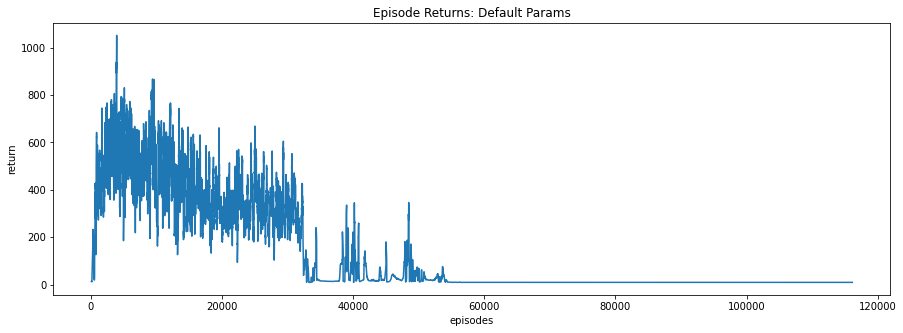

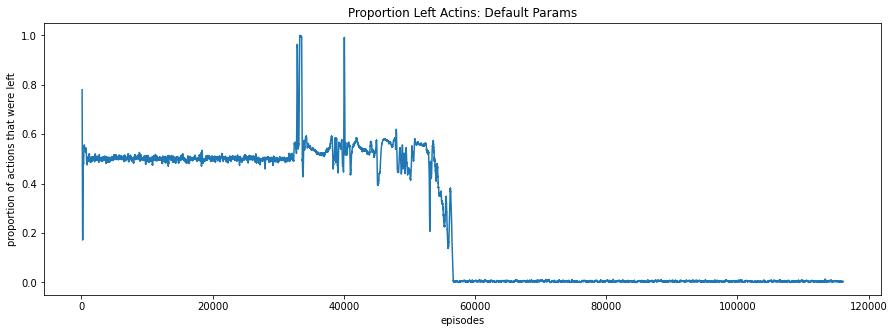

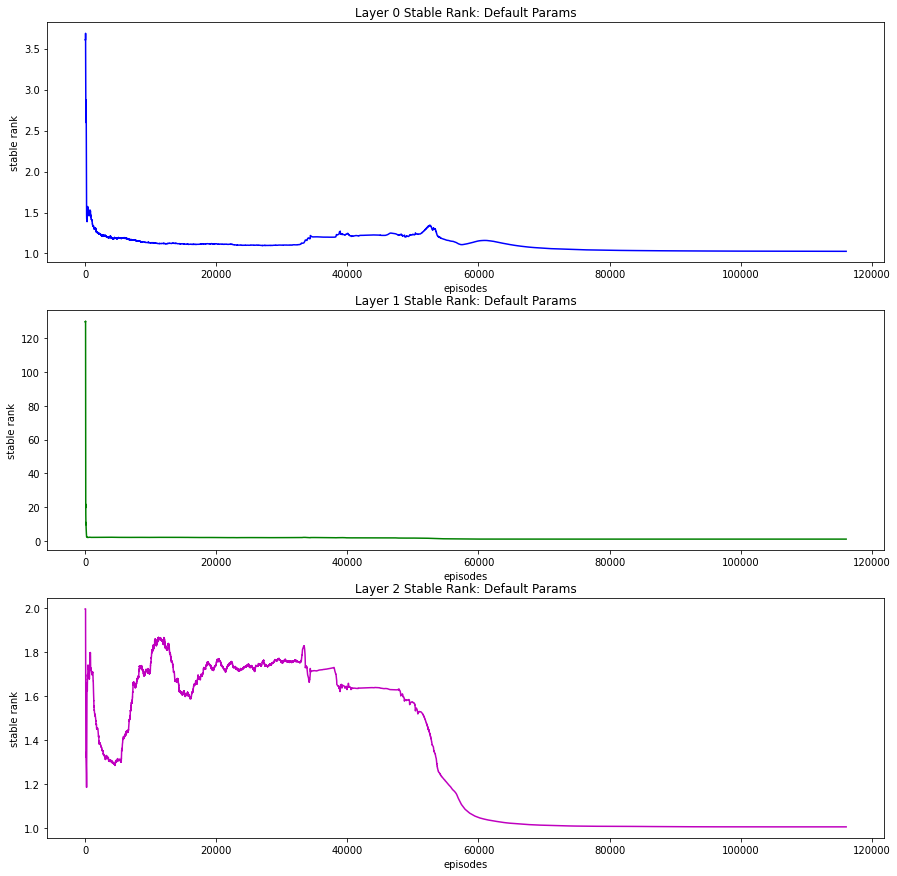

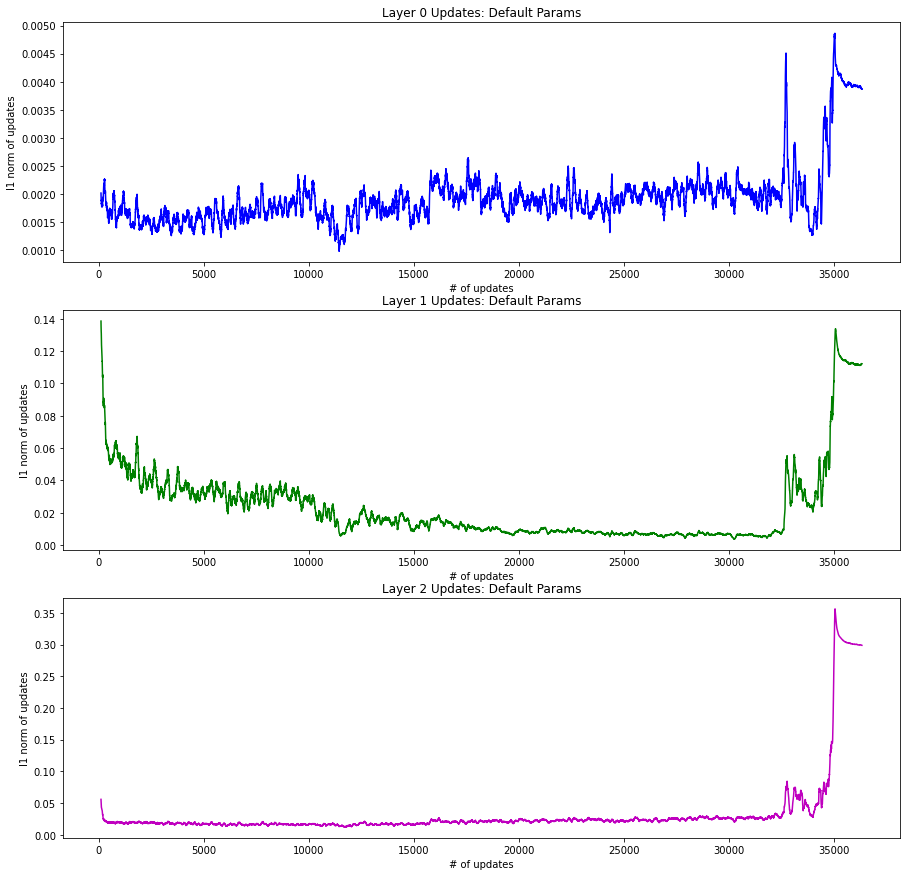

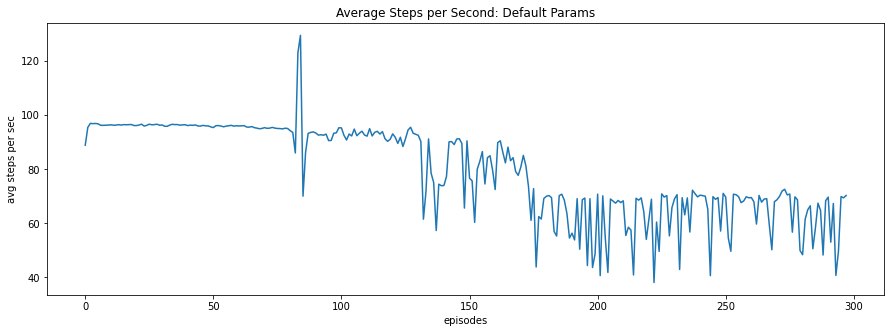

In [16]:
exp_data = parse_logs("Default Params", LOG_PATH, 300)

## Plot the Data (Single experiment)

In [ ]:
exp_data.plot_returns(window_size=100, should_save=False)
exp_data.plot_prop_left(window_size=100, should_save=False)
exp_data.plot_rank(window_size=1, should_save=False)
exp_data.plot_updates(window_size=100, should_save=False)
exp_data.plot_avg_steps_per_sec(should_save=False)

## Plotting Data from many experiments

Plotting: Seed=54321


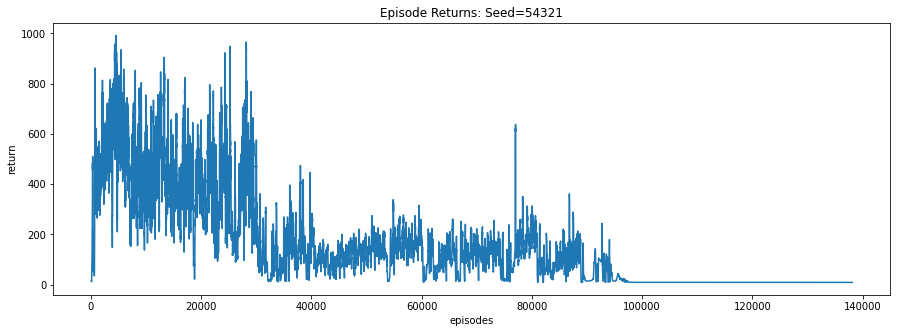

Plotting: Default DQN Params


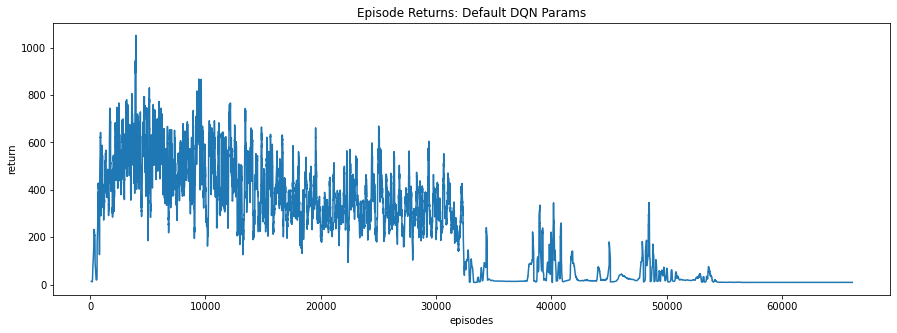

Plotting: Seed=678910


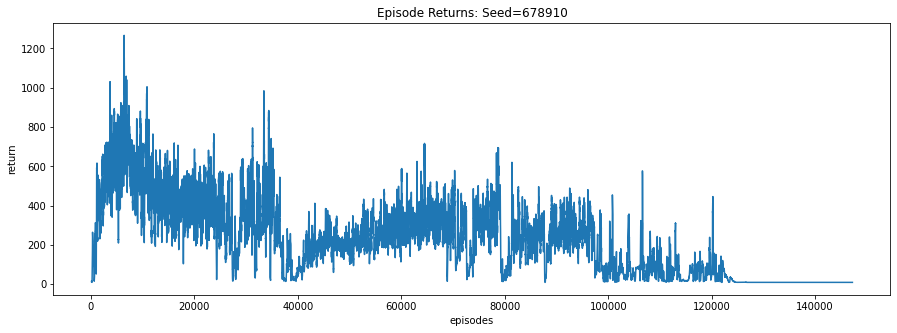

Plotting: Seed=12345


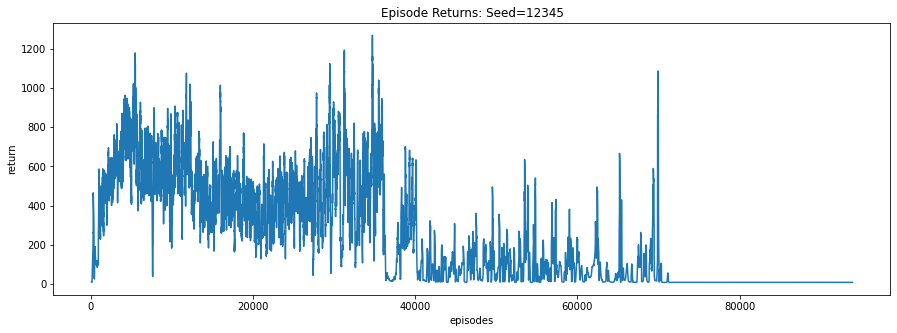

Plotting: Beta1=0, Beta2=0.999


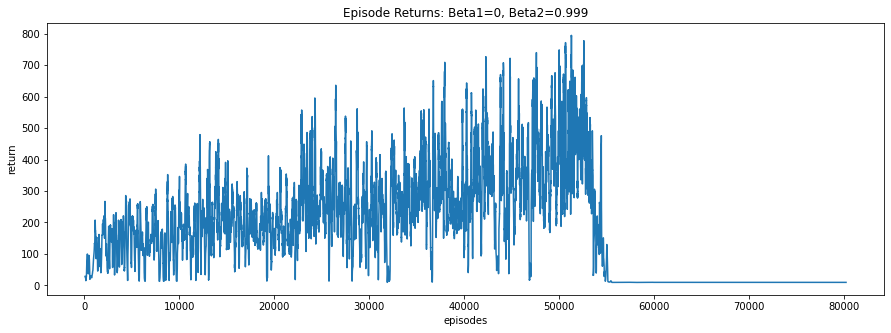

Plotting: Beta1=0, Beta2=0.99


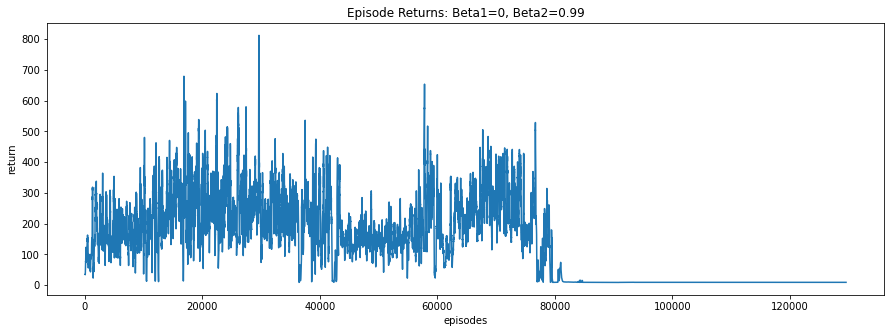

In [10]:
LOG_DIRECTORY = '../../tmp-cc/cartpole/'

class PlotConfig():
    def __init__(self, hash, name, logs_cutoff):
        self.name = name
        self.logs_cutoff = logs_cutoff
        self.logs_path = f"{LOG_DIRECTORY}/{hash}/logs"
    
    def parse_logs(self):
        return parse_logs(self.name, self.logs_path, self.logs_cutoff)

def get_experiment_name(exp_dir):
    for file in os.listdir(f"{LOG_DIRECTORY}/{exp_dir}"):
        if file.endswith(".gin"):
            return os.path.splitext(file)[0]
    return exp_dir

def plot_exploratory():
    """Parses and plots logs for all experiments in LOG_DIRECTORY"""
    for exp_dir in os.listdir(LOG_DIRECTORY):
        if exp_dir == '.DS_Store':
            continue
        
        exp_name = get_experiment_name(exp_dir)
        print(f"hash: {exp_dir}, experiment name: {exp_name}")

        # Parse logs
        logs_path = f"{LOG_DIRECTORY}/{exp_dir}/logs"
        exp_data = parse_logs(exp_name, logs_path)

        # Plot
        exp_data.plot_returns(window_size=100, should_save=False)

plot_cfgs = [
    PlotConfig("545fea39c5090d51c617d711e5f80f1af7173a4f", "Seed=54321", 350),
    PlotConfig("83bd9453492a7242c2034a1617cc856fb8e6ebec", "Default DQN Params", 200),
    PlotConfig("727d5e2fe65a229810709b6ffa84c55a6e131929", "Seed=678910", None),
    PlotConfig("24600938b186bdfa2aa763d8c13b4e146767f178", "Seed=12345", 300),
    PlotConfig("b611770428fa678aa46edd222c3b3ec8baeb9214", "Beta1=0, Beta2=0.999", 200),
    PlotConfig("bae07a929b555ca2f0395f5acf45fba0be57bfba", "Beta1=0, Beta2=0.99", None),
]

for plot_cfg in plot_cfgs:
    print(f"Plotting: {plot_cfg.name}")
    exp_data = plot_cfg.parse_logs()
    exp_data.plot_returns(window_size=100, should_save=False)

# plot_exploratory()